In [6]:
import pandas as pd

data = pd.read_csv('fraudtrain.csv')

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.sparse import csr_matrix, vstack

# Function to process data in chunks and convert to sparse matrix
def process_data_chunks(file_path, chunk_size):
    chunks = pd.read_csv(file_path, chunksize=chunk_size)
    sparse_chunks = []
    
    # Example: Initialize StandardScaler and OneHotEncoder
    scaler = StandardScaler()
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=True)
    
    for chunk in chunks:
        # Example: Perform feature engineering on each chunk
        chunk['trans_hour'] = pd.to_datetime(chunk['trans_date_trans_time']).dt.hour
        chunk['trans_day_of_week'] = pd.to_datetime(chunk['trans_date_trans_time']).dt.dayofweek
        
        # Example: Scaling numerical features
        numerical_features = ['amt', 'lat', 'long', 'city_pop']
        chunk[numerical_features] = scaler.fit_transform(chunk[numerical_features])
        
        # Example: Apply OneHotEncoder to categorical features
        categorical_features = ['merchant', 'category', 'gender']
        encoded_features = encoder.fit_transform(chunk[categorical_features])
        
        # Convert to sparse matrix
        sparse_data = csr_matrix(encoded_features)
        sparse_chunks.append(sparse_data)
    
    # Concatenate all sparse chunks into a single sparse matrix
    final_sparse_matrix = vstack(sparse_chunks)
    
    return final_sparse_matrix

# Example usage
file_path = 'fraudTrain.csv'  # Replace with your actual dataset file path
chunk_size = 100000  # Adjust based on your system's memory capacity

final_sparse_matrix = process_data_chunks(file_path, chunk_size)
print("Final sparse matrix shape:", final_sparse_matrix.shape)


c:\Users\smadh\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\smadh\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\smadh\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\smadh\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. 

Final sparse matrix shape: (1296675, 709)


c:\Users\smadh\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
# Example: Train and evaluate a model (Isolation Forest)
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score

# Assuming final_sparse_matrix is your processed sparse matrix and is_fraud is your target variable
X = final_sparse_matrix
y = data['is_fraud']

# Train-test split if not already done
# Example: Splitting data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Without the SMOTE

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from collections import Counter
# Assuming X_train, X_test, y_train, y_test are your training and test sets
print("Original training dataset shape:", Counter(y_train))

# Train logistic regression with class weight adjustment
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred)}')


Original training dataset shape: Counter({0: 1031354, 1: 5986})


c:\Users\smadh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       1.00      0.69      0.81    257815
           1       0.01      0.70      0.03      1520

    accuracy                           0.69    259335
   macro avg       0.51      0.69      0.42    259335
weighted avg       0.99      0.69      0.81    259335

ROC AUC Score: 0.6923751999342654


After Applying the SMOTE

In [41]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.sparse import csr_matrix, vstack, hstack
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from collections import Counter

# Function to process data in chunks and convert to sparse matrix
def process_data_chunks(file_path, chunk_size, scaler, encoder):
    chunks = pd.read_csv(file_path, chunksize=chunk_size)
    sparse_chunks = []
    
    for chunk in chunks:
        # Feature engineering
        chunk['trans_hour'] = pd.to_datetime(chunk['trans_date_trans_time']).dt.hour
        chunk['trans_day_of_week'] = pd.to_datetime(chunk['trans_date_trans_time']).dt.dayofweek
        
        # Scaling numerical features
        numerical_features = ['amt', 'lat', 'long', 'city_pop']
        chunk[numerical_features] = scaler.transform(chunk[numerical_features])
        
        # OneHotEncoding categorical features
        categorical_features = ['merchant', 'category', 'gender']
        encoded_features = encoder.transform(chunk[categorical_features])
        
        # Combine numerical and encoded categorical features
        sparse_data = csr_matrix(chunk[numerical_features])
        combined_data = hstack([sparse_data, encoded_features])
        sparse_chunks.append(combined_data)
    
    # Concatenate all sparse chunks into a single sparse matrix
    final_sparse_matrix = vstack(sparse_chunks)
    
    return final_sparse_matrix

# Load initial chunk to fit the scaler and encoder
initial_chunk = pd.read_csv('fraudtrain.csv', nrows=100000)
initial_chunk['trans_hour'] = pd.to_datetime(initial_chunk['trans_date_trans_time']).dt.hour
initial_chunk['trans_day_of_week'] = pd.to_datetime(initial_chunk['trans_date_trans_time']).dt.dayofweek

# Initialize and fit scaler and encoder
numerical_features = ['amt', 'lat', 'long', 'city_pop']
categorical_features = ['merchant', 'category', 'gender']
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore', sparse=True)
scaler.fit(initial_chunk[numerical_features])
encoder.fit(initial_chunk[categorical_features])

# Process the full dataset in chunks
file_path = 'fraudtrain.csv'
chunk_size = 100000
final_sparse_matrix = process_data_chunks(file_path, chunk_size, scaler, encoder)

# Load target variable
data = pd.read_csv('fraudtrain.csv', usecols=['is_fraud'])
y = data['is_fraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(final_sparse_matrix, y, test_size=0.1, random_state=42)

# Handling imbalanced data with SMOTE
print("Original training dataset shape:", Counter(y_train))
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Resampled training dataset shape:", Counter(y_train_res))

# Train logistic regression
model = LogisticRegression(random_state=42)
model.fit(X_train_res, y_train_res)

# Predict on the test set
y_pred = model.predict(X_train_res)

# Evaluate the model
print(classification_report(y_train_res, y_pred))
print(f'ROC AUC Score: {roc_auc_score(y_train_res, y_pred)}')


c:\Users\smadh\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Original training dataset shape: Counter({0: 1160274, 1: 6733})
Resampled training dataset shape: Counter({0: 1160274, 1: 1160274})


c:\Users\smadh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.79      0.88      0.84   1160274
           1       0.87      0.77      0.82   1160274

    accuracy                           0.83   2320548
   macro avg       0.83      0.83      0.83   2320548
weighted avg       0.83      0.83      0.83   2320548

ROC AUC Score: 0.8261233984386447


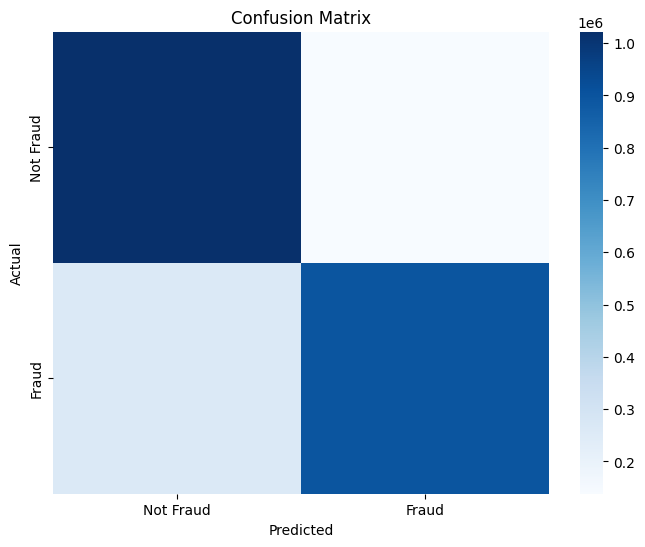

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Generate and plot confusion matrix
conf_matrix = confusion_matrix(y_train_res, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [17]:
data = pd.read_csv('fraudTest.csv')
y1 = data['is_fraud']
file_path = 'fraudtest.csv'
chunk_size = 100000
numerical_features = ['amt', 'lat', 'long', 'city_pop']
categorical_features = ['merchant', 'category', 'gender']
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore', sparse=True)
scaler.fit(initial_chunk[numerical_features])
encoder.fit(initial_chunk[categorical_features])
X1= process_data_chunks(file_path, chunk_size, scaler, encoder)
y_pred = model.predict(X1)

# Evaluate the model
print(classification_report(y1, y_pred))
print(f'ROC AUC Score: {roc_auc_score(y1, y_pred)}')



c:\Users\smadh\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.87      0.93    553574
           1       0.02      0.76      0.04      2145

    accuracy                           0.87    555719
   macro avg       0.51      0.81      0.49    555719
weighted avg       1.00      0.87      0.93    555719

ROC AUC Score: 0.8149048897537808
